In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn import metrics, linear_model, model_selection
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor, BaggingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.stats import hypergeom
from statsmodels.stats.multitest import multipletests as multpl
import GEOparse
from scipy import stats as stat
import random
import networkx as nx
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
import seaborn as sns

roc_auc_scorer = metrics.make_scorer(metrics.roc_auc_score)
scaler = StandardScaler()

In [ ]:
#Подгружаем данные

data = pd.read_csv('./Data/train_test.csv', index_col=0)
data_valid = pd.read_csv('./Data/validation.csv', index_col=0)


X = data.drop('index', axis=1)
y = list(map(int, data['index'] == 'HCM'))

X_valid = data_valid.drop('index', axis=1)
y_valid = list(map(int, data_valid['index'] == 'HCM'))

#X_valid_norm = scaler.fit_transform(X_valid)

In [3]:
print(X.shape)
print(X_valid.shape)

(145, 14830)
(16, 14830)


In [4]:
sum(y_valid)

5

#             feature selection

In [253]:
# train test split and normalisation


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)

In [254]:
C = np.array([10, 5, 1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.05, 0.02])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


[<matplotlib.lines.Line2D at 0x7fd1925d5610>]

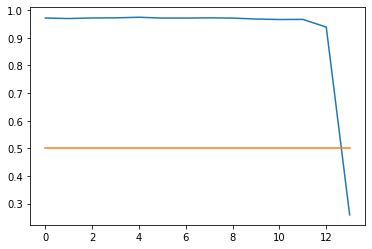

In [255]:
# Подбираем коэффициент регуляризации

result_df_train = pd.DataFrame()
result_df_test = pd.DataFrame()

for a in range(0,20):
    print(a)
    random_state = random.randint(1,100)
    roc_auc_train = list()
    roc_auc_test = list()
    for i in C:
        linear_regressor = linear_model.LogisticRegression(penalty='l1', C=i, solver='liblinear', random_state=random_state)
        linear_regressor.fit(X_train, y_train)
        roc_auc_train.append(np.mean(cross_val_score(linear_regressor, X_train, y_train, cv=3)))
        roc_auc_test.append(metrics.roc_auc_score(y_test, linear_regressor.predict(X_test)))
    result_df_train[a] = roc_auc_train
    result_df_test[a] = roc_auc_test

plt.plot(result_df_train.apply(np.mean, axis=1))
plt.plot(result_df_test.apply(np.mean, axis=1))

[<matplotlib.lines.Line2D at 0x7fd12381fc90>]

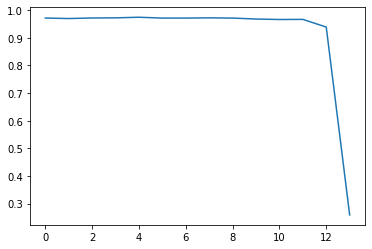

In [256]:
plt.plot(result_df_train.apply(np.mean, axis=1))

In [32]:
best_features = dict()
score_list = list()
ITER = 1000
for _ in range(0,ITER):
    random_state = random.randint(1,500)
    linear_regressor = linear_model.LogisticRegression(penalty='l1', C=C[11], solver='liblinear', random_state=random_state)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)
    linear_regressor.fit(X_train, y_train)
    mask = linear_regressor.coef_ != 0
    score = np.mean(cross_val_score(linear_regressor, X_test, y_test, cv=3))
    score_list.append(score)
    for i in X.columns[mask[0]]:
        if i in best_features:
            best_features[i]+=1/ITER*score
        else:
            best_features[i]=1/ITER*score

In [277]:
np.mean(score_list)

0.8439349206349207

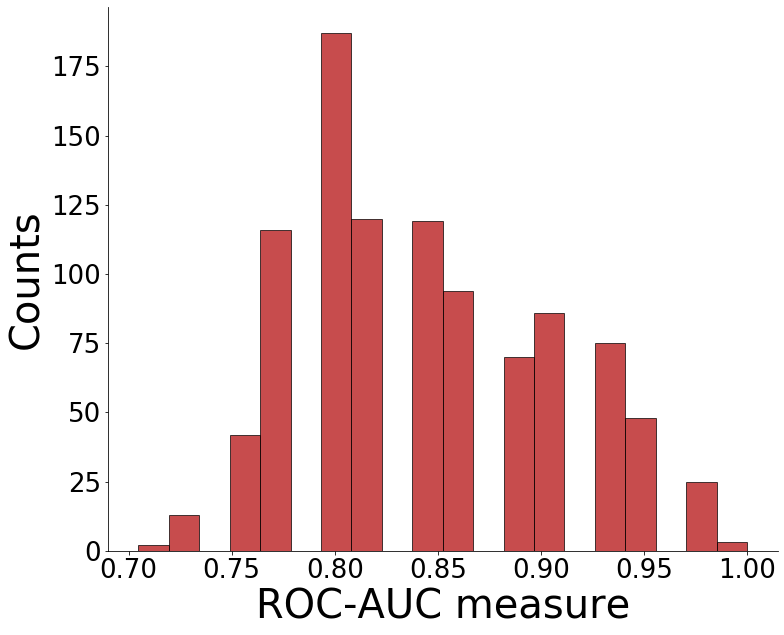

In [258]:
plt.figure(figsize=(12, 10))
plt.hist(score_list, bins=20, color=(176/255, 0, 2/255, 1), alpha=0.7, edgecolor='black')
plt.xlabel('ROC-AUC measure', fontsize=40)
plt.ylabel('Counts', fontsize=40)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
# Убираем верхнюю и правую границы осей
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)


# Сохраняем гистограмму в файл
plt.savefig('/Users/german/Dropbox/CardioCenter/Papers/2023/ML_miRNA/Results/histogram1_MC.png', dpi=300, bbox_inches='tight')

plt.show()

In [278]:
for k, v in best_features.items():
    if v > 0.6:
        print(k)

PIK3IP1
SMOC2
LMOD2
RASL11B
ACE2
SFRP1
TPM3
CENPA
FRZB
S100A9
PROS1
SERPINA3
RASD1
CA3
THBS4
CLIC6


In [80]:
G = nx.read_graphml('/Users/german/Downloads/Download/mirnet.graphml')
name_dict = dict()
for node, data in G.nodes(data=True):
    name_dict[node] = data['name']
G = nx.relabel_nodes(G, name_dict)    

In [78]:
node_attr = best_features.copy()

In [88]:
for node in G.nodes():
    if 'hsa-mir' in node:
        neighbors = list(G.neighbors(node))
        neighbor_weight_sum = sum([best_features[neighbor] for neighbor in neighbors])
        node_attr[node] = neighbor_weight_sum

In [91]:
nx.set_node_attributes(G, node_attr, 'weight')

In [96]:
node_sizes = [G.nodes[node]['weight'] * 50 for node in G.nodes]

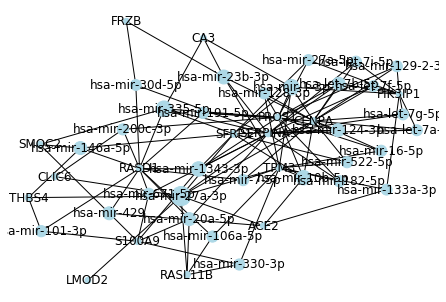

In [97]:
pos = nx.spring_layout(G)  # Вычисляем позиции узлов
nx.draw(G, pos, with_labels=True, node_size=node_sizes, node_color='lightblue')

plt.show()

In [225]:
data = []

# Проходим через каждый узел и получаем его соседей и вес
for node in G.nodes:
    neighbors = list(G.neighbors(node))
    weight = G.nodes[node]['weight']
    data.append({'Node': node, 'Neighbors': neighbors, 'Weight': weight})

# Создаем DataFrame из списка данных
df = pd.DataFrame(data)

# Упорядочиваем DataFrame по параметру weight
df = df.sort_values(by='Weight', ascending=False)

In [227]:
df.to_csv('/Users/german/Dropbox/CardioCenter/Papers/2023/ML_miRNA/nodes_neigbors.csv', index=False)

In [99]:
nodes_data = [(node, data['weight']) for node, data in G.nodes(data=True)]

In [101]:
nodes_df = pd.DataFrame(nodes_data, columns=['Node', 'Weight'])

In [103]:
edges_data = [(edge[0], edge[1]) for edge in G.edges()]
edges_df = pd.DataFrame(edges_data, columns=['Source', 'Target'])

In [105]:
edges_df.to_csv('./edges.csv', index=False)
nodes_df.to_csv('./nodes.csv', index=False)

In [202]:
interest_miRNA = {'hsa-miR-16-5p', 'hsa-miR-27a-3p', 'hsa-miR-10b-5p', 'hsa-miR-1-3p', 'hsa-miR-23b-3p', 'hsa-miR-133a-3p', 'hsa-miR-146a-5p', 'hsa-miR-335-5p', 'hsa-miR-27a-5p', 'hsa-let-7a-5p', 'hsa-let-7b-5p', 'hsa-let-7f-5p', 'hsa-let-7g-5p', 'hsa-let-7i-5p', 'hsa-miR-129-2-3p', 'hsa-miR-124-3p', 'hsa-miR-522-5p', 'hsa-miR-1343-3p', 'hsa-miR-106a-5p', 'hsa-miR-20a-5p', 'hsa-miR-30d-5p', 'hsa-miR-101-3p', 'hsa-miR-191-5p', 'hsa-miR-200c-3p', 'hsa-miR-429', 'hsa-miR-671-5p', 'hsa-miR-7-5p', 'hsa-miR-128-3p', 'hsa-miR-330-3p', 'hsa-miR-182-5p'}
interest_miRNA_ = {'hsa-miR-16', 'hsa-miR-27a', 'hsa-miR-10b', 'hsa-miR-1', 'hsa-miR-23b', 'hsa-miR-133a', 'hsa-miR-146a', 'hsa-miR-335', 'hsa-miR-27a', 'hsa-let-7a', 'hsa-let-7b', 'hsa-let-7f', 'hsa-let-7g', 'hsa-let-7i', 'hsa-miR-129-2', 'hsa-miR-124', 'hsa-miR-522', 'hsa-miR-1343', 'hsa-miR-106a', 'hsa-miR-20a', 'hsa-miR-30d', 'hsa-miR-101', 'hsa-miR-191', 'hsa-miR-200c', 'hsa-miR-429', 'hsa-miR-671', 'hsa-miR-7-1', 'hsa-miR-128', 'hsa-miR-330', 'hsa-miR-182'}

In [203]:
ilmn_mirna = dict()
for ind, name in enumerate(annotation.SYMBOL):
    if name in interest_miRNA:
        print(annotation.index[ind], name)
        ilmn_mirna[annotation.index[ind]] = name
        continue
    if name in interest_miRNA_:
        print(annotation.index[ind], name)
        ilmn_mirna[annotation.index[ind]] = name

ILMN_3167819 hsa-miR-522
ILMN_3168208 hsa-miR-330-3p
ILMN_3167510 hsa-miR-20a
ILMN_3167253 hsa-miR-191
ILMN_3167806 hsa-miR-429
ILMN_3167002 hsa-miR-200c
ILMN_3168483 hsa-miR-146a
ILMN_3167989 hsa-miR-16
ILMN_3168314 hsa-miR-133a
ILMN_3167808 hsa-miR-101
ILMN_3167276 hsa-miR-10b
ILMN_3167996 hsa-miR-335
ILMN_3167997 hsa-miR-23b
ILMN_3167189 hsa-let-7f
ILMN_3167971 hsa-let-7a
ILMN_3167970 hsa-let-7b
ILMN_3168365 hsa-let-7g
ILMN_3168316 hsa-let-7i
ILMN_3168320 hsa-miR-1
ILMN_3167224 hsa-miR-30d
ILMN_3168323 hsa-miR-27a
ILMN_3167755 hsa-miR-182
ILMN_3168544 hsa-miR-106a
ILMN_3168606 hsa-miR-671-5p
ILMN_3168781 hsa-miR-124
ILMN_3168806 hsa-miR-128


In [145]:
annotation

,SYMBOL,ILMN_Gene,Search_Key,Probe_Id,ProbeSeq,TargetMatureSeqs,TargetMatureName,NumTargets,TargetMatureVersion,OriginalMatureSeq,...,Array_Address_Id,Illumicode,Oligo,U3_Seq,Ploidy,Species,Probe_MatchOrder,Chromosome,Probe_Coordinates,Probe_Chr_Orientation
ILMN_3167151,hsa-miR-553,hsa-miR-553,ILMN_3167151,AAAACGGTGAGATTTTGTT,AAAACGGTGAGATTTTGTTTT,hsa-miR-553,1.0,12.0,AAAACGGTGAGATTTTGTTTT,hsa-miR-553,...,TAGCTGGCCCACGAAATCTGCG,ACTTCGTCAGTAACGGACTAGCTGGCCCACGAAATCTGCGAAAACG...,ACTTCGTCAGTAACGGAC,diploid,human,1,1,100519399,+,NaN
ILMN_3167958,HS_124,HS_124,ILMN_3167958,AAAAGAACATGGGTTGAG,AAAAGAACATGGGTTGAG,HS_124,1.0,0.0,AAAAGAACATGGGTTGAG,HS_124,...,TGAGGTGACGCATCCCTCCATT,ACTTCGTCAGTAACGGACTGAGGTGACGCATCCCTCCATTAAAAGA...,ACTTCGTCAGTAACGGAC,diploid,human,1,0,0,+,NaN
ILMN_3167403,"hsa-miR-320d,hsa-miR-320b,hsa-miR-320a,hsa-miR...","hsa-miR-320d,hsa-miR-320b,hsa-miR-320a,hsa-miR...",ILMN_3167403,AAAAGCTGGGTTGAGAGG,"AAAAGCTGGGTTGAGAGGA,AAAAGCTGGGTTGAGAGGGCAA,AAA...","hsa-miR-320d,hsa-miR-320b,hsa-miR-320a,hsa-miR...",4.0,12.0,AAAAGCTGGGTTGAGAGGGCGAA,hsa-miR-320,...,ACCCGATGGATAGGTCGGTGAA,ACTTCGTCAGTAACGGACACCCGATGGATAGGTCGGTGAAAAAAGC...,ACTTCGTCAGTAACGGAC,diploid,human,"2,2,1,2","13,X,1,1,8,18,18","40199983,139836022,117015931,222511396,2215845...","-,-,+,-,-,+,+",NaN
ILMN_3167819,hsa-miR-522,hsa-miR-522,ILMN_3167819,AAAATGGTTCCCTTTAGAGT,AAAATGGTTCCCTTTAGAGTGT,hsa-miR-522,1.0,12.0,AAAATGGTTCCCTTTAGAGTGTT,hsa-miR-522,...,CAGTAATCAGGCGTCTGTTGGC,ACTTCGTCAGTAACGGACCAGTAATCAGGCGTCTGTTGGCAAAATG...,ACTTCGTCAGTAACGGAC,diploid,human,1,19,58946329,+,NaN
ILMN_3167659,hsa-miR-1537,hsa-miR-1537,ILMN_3167659,AAACCGTCTAGTTACAGTTGT,AAAACCGTCTAGTTACAGTTGT,hsa-miR-1537,1.0,12.0,AAACCGTCTAGTTACAGTTGT,HS_92.1,...,CAGTCAGCAGCCGATCTCGGAT,ACTTCGTCAGTAACGGACCAGTCAGCAGCCGATCTCGGATAAACCG...,ACTTCGTCAGTAACGGAC,diploid,human,1,1,234082945,-,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Contamination_Controls,2,Negative (snoRNA234-1),PCR Contamination_Blue,TRUE,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Extension_Controls,1,Perfect Match,extension mismatch control_Red,TRUE,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Extension_Controls,2,Mismatch,extension mismatch control_Blue,TRUE,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Hyb_Controls,1,Hyb 1,Array hyb control_Med,TRUE,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [204]:
mir_data = pd.read_csv('/Users/german/Dropbox/CardioCenter/Papers/2023/ML_miRNA/Data/miRNA_dataset/GSE36946_non-normalized (1).txt', 
                       sep='\t', index_col=0)
annotation = pd.read_csv('/Users/german/Dropbox/CardioCenter/Papers/2023/ML_miRNA/Data/miRNA_dataset/GPL8179_humanMI_V2_R0_XS0000124-MAP.txt', sep='\t')

In [205]:
mir_data.columns

Index(['12799_miRNA', '12799_miRNA.Pval', '1403_miRNA', '1403_miRNA.Pval',
       '17_miRNA', '17_miRNA.Pval', '171102_miRNA', '171102_miRNA.Pval',
       '18_miRNA', '18_miRNA.Pval',
       ...
       'RNM06_miRNA', 'RNM06_miRNA.Pval', 'RNM07_miRNA', 'RNM07_miRNA.Pval',
       'RNM08_miRNA', 'RNM08_miRNA.Pval', 'RR632698_miRNA',
       'RR632698_miRNA.Pval', 'RRNM09_miRNA', 'RRNM09_miRNA.Pval'],
      dtype='object', length=254)

In [138]:
for i, m in enumerate(['a','c','d']):
    print(i)

0
1
2


In [206]:
mask = list()
for ind, name in enumerate(mir_data.columns):
    if '.Pval' not in name:
        mask.append(ind)

mask_row = list()
for ind, name in enumerate(mir_data.index):
    if name in ilmn_mirna.keys():
        mask_row.append(ind)

In [207]:
mir_data = mir_data.iloc[mask_row,mask]

In [208]:
mir_data = mir_data.transpose()

In [209]:
mir_data = mir_data.rename(columns=ilmn_mirna)

In [210]:
sample_name = ["7_miRNA","R26_miRNA","670934_miRNA","NM10_miRNA","666295_miRNA","644621_miRNA","37_miRNA","R40_miRNA","54_miRNA","588103_miRNA","R57_miRNA","RNM07_miRNA","20_miRNA","RNM01_miRNA","635265_miRNA","635263_miRNA","56_miRNA","RRNM09_miRNA","33_miRNA","676073_miRNA","25_miRNA","18_miRNA","22_miRNA","639124_miRNA","RR632698_miRNA","R1_miRNA","29_miRNA","R16_miRNA","R53_miRNA","669841_miRNA","9_miRNA","17_miRNA","24_miRNA","656880_miRNA","647526_miRNA","R59_miRNA","R607466_miRNA","R619278_miRNA","587005_miRNA","36_miRNA","44_miRNA","RNM02_miRNA","RNM05_miRNA","RNM08_miRNA","R32_miRNA","649284_miRNA","41_miRNA","45_miRNA","680701_miRNA","R655639_miRNA","632093_miRNA","653513_miRNA","653809_miRNA","R342632_miRNA","633322_miRNA","656578_miRNA","R8_miRNA","R58_miRNA","NM03_miRNA","27_miRNA","R50_miRNA","RNM06_miRNA","48_miRNA","49_miRNA","610700_miRNA","R620009_miRNA","46_miRNA","R656518_miRNA","370118_miRNA","687046_miRNA","653447_miRNA","663702_miRNA","663118_miRNA","673367_miRNA","683304_miRNA","638751_miRNA","645586_miRNA","661552_miRNA","631131_miRNA","RNM04_miRNA","653448_miRNA","47_miRNA","647527_miRNA","637810_miRNA","634021_miRNA","R671993_miRNA","R35_miRNA","3_miRNA","670152_miRNA","30_miRNA","631132_miRNA","R633573_miRNA","639649_miRNA","39_miRNA","28_miRNA","673368_miRNA","671852_miRNA","43_miRNA","629740_miRNA","673482_miRNA","R634935_miRNA","R643724_miRNA","639123_miRNA","655638_miRNA","627047_miRNA","676236_miRNA","R34_miRNA","5089_miRNA","5059_miRNA","431840_miRNA","R5144_miRNA","R26309_miRNA","R300305_miRNA","R5126_miRNA","5140_miRNA","22100_miRNA","171102_miRNA","91099_miRNA","191002_miRNA","4049_miRNA","1403_miRNA","12799_miRNA","4062_miRNA","5603_miRNA","A505654_miRNA","A702013_miRNA","A809126_miRNA"]
sample_status = ["HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","HCM","CTRL","CTRL","CTRL","CTRL","CTRL","CTRL","CTRL","CTRL","CTRL","CTRL","CTRL","CTRL","CTRL","CTRL","CTRL","CTRL","CTRL","CTRL","CTRL","CTRL"]

sample_dict = dict()
for i in range(len(sample_name)):
    sample_dict[sample_name[i]] = sample_status[i]

In [211]:
mir_data_target = list()

for i in mir_data.index:
    if sample_dict[i] == "HCM":
        mir_data_target.append(1)
    else:
        mir_data_target.append(0)

In [212]:
mir_data_target

[0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

Столбец 'hsa-let-7a': P-значение (поправка): 0.15672464200952785

Столбец 'hsa-let-7b': P-значение (поправка): 0.15672464200952785

Столбец 'hsa-let-7f': P-значение (поправка): 0.15672464200952785

Столбец 'hsa-let-7g': P-значение (поправка): 0.15773612743480445

Столбец 'hsa-let-7i': P-значение (поправка): 0.15672464200952785

Столбец 'hsa-miR-1': P-значение (поправка): 0.15672464200952785

Столбец 'hsa-miR-101': P-значение (поправка): 0.4536791782081802

Столбец 'hsa-miR-106a': P-значение (поправка): 0.04148794983807208
Отвергаем нулевую гипотезу: выборки неоднородны.

Столбец 'hsa-miR-10b': P-значение (поправка): 0.12591864880247358

Столбец 'hsa-miR-124': P-значение (поправка): 0.04148794983807208
Отвергаем нулевую гипотезу: выборки неоднородны.

Столбец 'hsa-miR-128': P-значение (поправка): 0.22885822758892785

Столбец 'hsa-miR-133a': P-значение (поправка): 0.1686609465077035

Столбец 'hsa-miR-146a': P-значение (поправка): 0.05484783597524915

Столбец 'hsa-miR-16': P-значение (поп

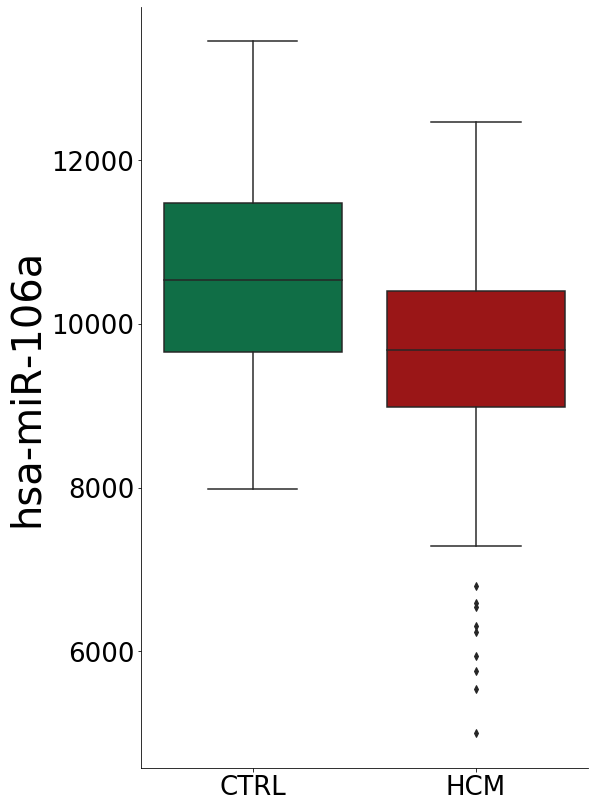

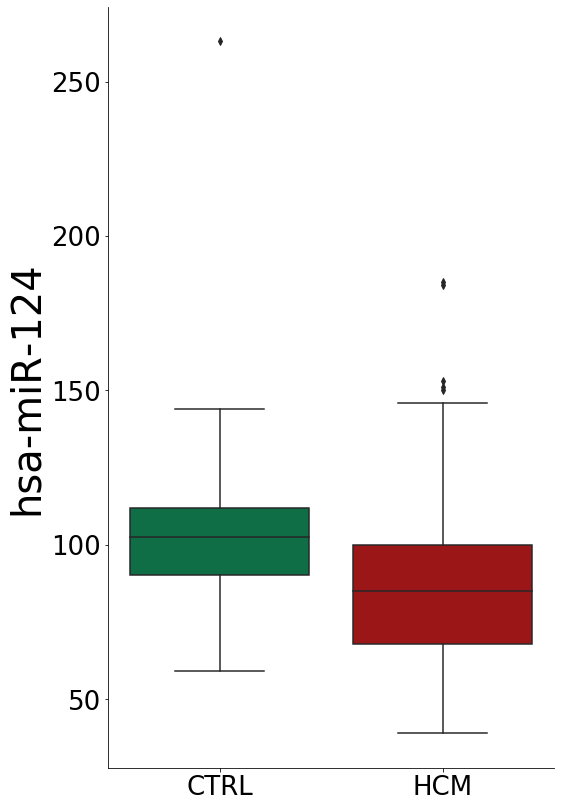

In [274]:
def mannwhitney_test(column, targets):
    group_0 = column[targets == 0]
    group_1 = column[targets == 1]
    statistic, p_value = mannwhitneyu(group_0, group_1)
    return p_value

# Применяем функцию к каждому столбцу
p_values = mir_data.apply(mannwhitney_test, args=(np.array(mir_data_target),))

# Уровень значимости
alpha = 0.05
_, p_values_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')

for column, p_value_corrected in zip(p_values.index, p_values_corrected):
    print(f"Столбец '{column}': P-значение (поправка): {p_value_corrected}")
    if p_value_corrected < alpha:
        print("Отвергаем нулевую гипотезу: выборки неоднородны.")
    print()

# Задаем цвета боксплотов в формате RGB
boxplot_colors = [(0, 126/255, 72/255, 1), (176/255, 0, 2/255, 1)]  # Пример цветов (красный, зеленый)

for column, p_value_corrected in zip(p_values.index, p_values_corrected):
    if p_value_corrected < 0.05:
        significant_column = mir_data[column]
        plt.figure(figsize=(8, 14))
        sns.boxplot(x=mir_data_target, y=significant_column, palette=boxplot_colors)
        plt.ylabel(column, fontsize=40)
        plt.xticks(fontsize=26)
        plt.yticks(fontsize=26)
        # Убираем верхнюю и правую границы осей
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        plt.xticks([0, 1], ['CTRL', 'HCM'])  # Заменяем метки на оси x
        
        filepath = '/Users/german/Dropbox/CardioCenter/Papers/2023/ML_miRNA/Results/'  # Замените на свой путь
        filename = f'{filepath}{column}_boxplot.png'
        
        plt.savefig(filename, bbox_inches='tight')
        
        plt.show()

ID_REF
hsa-let-7a        0.060596
hsa-let-7b        0.072334
hsa-let-7f        0.067235
hsa-let-7g        0.078868
hsa-let-7i        0.064320
hsa-miR-1         0.057053
hsa-miR-101       0.348984
hsa-miR-106a      0.003191
hsa-miR-10b       0.024215
hsa-miR-124       0.002595
hsa-miR-128       0.140836
hsa-miR-133a      0.090817
hsa-miR-146a      0.006329
hsa-miR-16        0.182307
hsa-miR-182       0.149976
hsa-miR-191       0.512299
hsa-miR-200c      0.783560
hsa-miR-20a       0.010129
hsa-miR-23b       0.175882
hsa-miR-27a       0.113673
hsa-miR-30d       0.072334
hsa-miR-330-3p    0.514426
hsa-miR-335       0.640768
hsa-miR-429       0.575918
hsa-miR-522       0.035019
hsa-miR-671-5p    0.740663
dtype: float64

In [266]:
miR_test_df = pd.DataFrame({'miR':p_values.index, 'p_value_adj':p_values_corrected, 'p_value':p_values})
miR_test_df.to_csv('/Users/german/Dropbox/CardioCenter/Papers/2023/ML_miRNA/Results/miR_test.csv', index=True)

In [214]:
def mannwhitney_test(column, targets):
    group_0 = column[targets == 0]
    group_1 = column[targets == 1]
    statistic, p_value = mannwhitneyu(group_0, group_1)
    return p_value

# Применяем функцию к каждому столбцу
p_values = mir_data.apply(mannwhitney_test, args=(np.array(mir_data_target),))

# Уровень значимости
alpha = 0.05

for column, p_value in p_values.items():
    print(f"Столбец '{column}': P-значение: {p_value}")
    if p_value < alpha:
        print("Отвергаем нулевую гипотезу: выборки неоднородны.")
    print()

Столбец 'hsa-let-7a': P-значение: 0.06059620908865763

Столбец 'hsa-let-7b': P-значение: 0.07233445015824362

Столбец 'hsa-let-7f': P-значение: 0.06723517454652524

Столбец 'hsa-let-7g': P-значение: 0.07886806371740222

Столбец 'hsa-let-7i': P-значение: 0.06431962334922223

Столбец 'hsa-miR-1': P-значение: 0.0570528684517723

Столбец 'hsa-miR-101': P-значение: 0.3489839832370617

Столбец 'hsa-miR-106a': P-значение: 0.0031913807567747754
Отвергаем нулевую гипотезу: выборки неоднородны.

Столбец 'hsa-miR-10b': P-значение: 0.02421512476970646
Отвергаем нулевую гипотезу: выборки неоднородны.

Столбец 'hsa-miR-124': P-значение: 0.0025947935425289794
Отвергаем нулевую гипотезу: выборки неоднородны.

Столбец 'hsa-miR-128': P-значение: 0.14083583236241715

Столбец 'hsa-miR-133a': P-значение: 0.09081743273491726

Столбец 'hsa-miR-146a': P-значение: 0.006328596458682594
Отвергаем нулевую гипотезу: выборки неоднородны.

Столбец 'hsa-miR-16': P-значение: 0.18230657374588688

Столбец 'hsa-miR-182':

In [193]:
p_values

ID_REF
hsa-let-7a        6.059621e-02
hsa-let-7b        7.233445e-02
hsa-let-7f        6.723517e-02
hsa-let-7g        7.886806e-02
hsa-let-7i        6.431962e-02
hsa-miR-1         5.705287e-02
hsa-miR-101       3.489840e-01
hsa-miR-106a      3.191381e-03
hsa-miR-10b       2.421512e-02
hsa-miR-124       2.594794e-03
hsa-miR-128       1.408358e-01
hsa-miR-133a      9.081743e-02
hsa-miR-146a      6.328596e-03
hsa-miR-16        1.823066e-01
hsa-miR-182       1.499758e-01
hsa-miR-191       5.122989e-01
hsa-miR-200c      7.835603e-01
hsa-miR-20a       1.012880e-02
hsa-miR-23b       1.758816e-01
hsa-miR-27a       1.136733e-01
hsa-miR-30d       7.233445e-02
hsa-miR-330-3p    5.144260e-01
hsa-miR-335       6.407678e-01
hsa-miR-429       5.759183e-01
hsa-miR-522       3.501907e-02
hsa-miR-671-5p    7.406630e-01
hsa-miR-7         3.007758e-07
dtype: float64